Найден минимум функции: f(0.9973337794905124, 0.9941906061743825) = 3.054028910562738e-5


┌ Info: Saved animation to c:\Users\Golum\Desktop\iu9-education\optimization-methods\letuchka-17-04-2025\rosenbrock_genetic_algorithm_3d.gif
└ @ Plots C:\Users\Golum\.julia\packages\Plots\kLeqV\src\animation.jl:156
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is invalid in routine SET_COLOR_REP
GKS: Colour is in

Plots.AnimatedGif("c:\\Users\\Golum\\Desktop\\iu9-education\\optimization-methods\\letuchka-17-04-2025\\rosenbrock_genetic_algorithm_3d.gif")
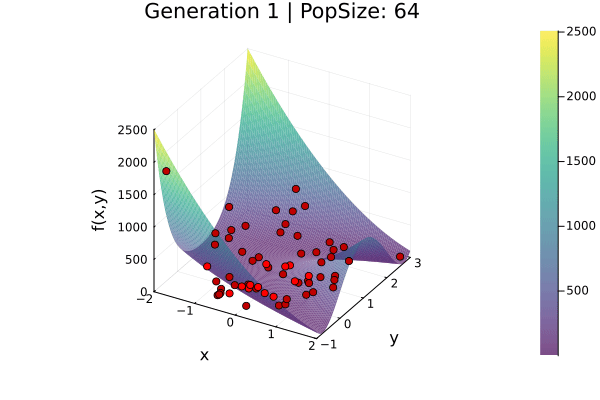

In [1]:
using Plots, Random, Colors

f(x, y) = (1 - x)^2 + 100*(y - x^2)^2

struct Individual
    x::Float64
    y::Float64
    age::Int
    max_age::Int
    fitness::Float64
end

function initialize_population(size, x_min, x_max, y_min, y_max, min_age, max_age)
    pop = [create_individual(rand()*(x_max-x_min)+x_min, 
                           rand()*(y_max-y_min)+y_min, 
                           0, min_age, max_age, []) for _ in 1:size]
    return pop
end

function create_individual(x, y, age, min_age, max_age, f_values)
    fit = f(x, y)
    ma = compute_max_age(fit, f_values, min_age, max_age)
    return Individual(x, y, age, ma, fit)
end

function compute_max_age(fit, f_values, min_age, max_age)
    if isempty(f_values)
        return min_age + (max_age - min_age) ÷ 2
    end
    f_min, f_max = extrema(f_values)
    normalized = f_max != f_min ? (f_max - fit) / (f_max - f_min) : 0.5
    return min_age + round(Int, normalized * (max_age - min_age))
end

# Параметры
x_min = -2.0
x_max = 2.0
y_min = -1.0
y_max = 3.0
p = 0.27
mutation_strength = 0.1
min_age = 1
max_age_param = 5
initial_pop_size = 50
generations = 50
max_pop_size = 1000

Random.seed!(42)
pop = initialize_population(initial_pop_size, x_min, x_max, y_min, y_max, min_age, max_age_param)

anim = @animate for gen in 1:generations
    global pop

    # Старение популяции
    pop = [Individual(ind.x, ind.y, ind.age + 1, ind.max_age, ind.fitness) for ind in pop]

    # Разделение на живых и мертвых
    alive = [ind for ind in pop if ind.age <= ind.max_age]
    dead = [ind for ind in pop if ind.age > ind.max_age]
    pop_size_current = length(alive)

    # Создание вспомогательной популяции
    aux_pop_size = round(Int, pop_size_current * p)
    f_values = [ind.fitness for ind in alive]
    aux_pop = []

    if !isempty(alive)
        fitnesses = [ind.fitness for ind in alive]
        _, idx = findmin(fitnesses)
        best_parent = alive[idx]
        
        for _ in 1:aux_pop_size
            parent1 = rand(alive)
            parent2 = best_parent
            α = rand()
            x_child = α * parent1.x + (1 - α) * parent2.x
            y_child = α * parent1.y + (1 - α) * parent2.y
            x_child += randn() * mutation_strength
            y_child += randn() * mutation_strength
            x_child = clamp(x_child, x_min, x_max)
            y_child = clamp(y_child, y_min, y_max)
            push!(aux_pop, create_individual(x_child, y_child, 0, min_age, max_age_param, f_values))
        end
    end

    pop = vcat(alive, aux_pop)

    # Контроль размера популяции
    if length(pop) > max_pop_size
        pop = sort(pop, by = x -> x.fitness)
        pop = pop[1:max_pop_size]
    end

    # Подготовка данных для 3D графика
    plot_x = range(x_min, x_max, length=100)
    plot_y = range(y_min, y_max, length=100)
    plot_f = [f(x,y) for x in plot_x, y in plot_y]
    
    # Создание 3D графика
    plt = surface(plot_x, plot_y, plot_f, 
                 color=:viridis, alpha=0.7,
                 xlim=(x_min, x_max), ylim=(y_min, y_max),
                 zlim=(0, maximum(plot_f)),
                 colorbar=true, legend=false)

    # Добавление точек популяции
    for ind in pop
        t = clamp(1.0 - ind.age / (ind.max_age + 1), 0.0, 1.0)
        col = RGB(t, 0.0, 0.0)
        scatter!(plt, [ind.x], [ind.y], [ind.fitness], 
                color=col, markersize=4, marker=:circle)
    end

    title!("Generation $gen | PopSize: $(length(pop))")
    xlabel!("x")
    ylabel!("y")
    zlabel!("f(x,y)")
end

best = pop[argmin([ind.fitness for ind in pop])]
println("Найден минимум функции: f($(best.x), $(best.y)) = $(best.fitness)")

gif(anim, "rosenbrock_genetic_algorithm_3d.gif", fps=8)